# ☆ Instacart Feast ☆

In [1]:
!pip3 install --upgrade mlxtend
!pip3 install apyori

# Importing Libraries

In [4]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False
    
if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'apriori/'
data_dir = groot_dir + 'apriori/'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)

def local_now(hours = 8):
    return datetime.datetime.now() + \
        relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def DropboxLink(did, fname):
    return 'https://dl.dropboxusercontent.com/s/%s/%s' % \
    (did, fname)

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier
    
def start_plot(figsize=(10, 8), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1,1)
    plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax
    
print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage points to ==>', data_dir)

print('\nThis module is aimed to learn market basket analysis...') 
print('\nLibraries and dependenciess imported') 
print_now()


Running on win32
Python Version 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
Data storage points to ==> C:\Users\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/apriori/

This module is aimed to learn market basket analysis...

Libraries and dependenciess imported
2021-05-28 14:33:27.273079


# Warm Up：store_data.csv

- [Association Rule Mining via Apriori Algorithm in Python](https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/)
- [data on Github](https://github.com/gitganeshnethi/Datasets/blob/master/store_data.csv)
- [Complete guide to Association Rules](https://towardsdatascience.com/complete-guide-to-association-rules-2-2-c92072b56c84)

### 將資料載入記憶體





In [5]:
fetch_file_via_requests(
    DropboxLink('9wcgqcl99efi12i', 'store_data.csv'), data_dir
)

'C:\\Users\\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/apriori/store_data.csv'

In [6]:
csv_path = os.path.join(data_dir, 'store_data.csv')
df = pd.read_csv(csv_path, header=None)

#將NaN改為空字串，以便後續處理
df.fillna('', inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,,,,,,,,,,,,,,,,,
2,chutney,,,,,,,,,,,,,,,,,,,
3,turkey,avocado,,,,,,,,,,,,,,,,,,
4,mineral water,milk,energy bar,whole wheat rice,green tea,,,,,,,,,,,,,,,


In [7]:
%%time

odata = []
items = set()

for i in range(len(df)):
    basket = set(df.iloc[i, :]).difference({''})
    for x in basket:
        items.add(x)
    # items = items.union(basket)
    odata.append(basket)

item_list = list(items)
item_list.sort()

Wall time: 1.11 s


In [8]:
#其他方法
df.iloc[3]

0      turkey
1     avocado
2            
3            
4            
5            
6            
7            
8            
9            
10           
11           
12           
13           
14           
15           
16           
17           
18           
19           
Name: 3, dtype: object

- odata : order data (list of list)
- item_list: list of goods

we need an array conatining all purachasing information. the array must be of the form 

(n_orders, n_items)

**用dataframe得到的結果**

In [9]:
%%time
def transform_order(items, order_list):
    data = np.full((len(order_list), len(items)), False)
    tfed = pd.DataFrame(data=data, columns=list(items))

    for i in range(len(df)):
        new_order = set(order_list[i])
        for x in new_order:
            tfed.iloc[i][x] = True
    return tfed

Wall time: 0 ns


In [10]:
%%time
rdf = transform_order(item_list, odata)

Wall time: 2.09 s


In [11]:
rdf.head()

,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,True,True,False,True,False,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


**用np.array得到結果**

In [12]:
%%time
def transform_order2(items, order_list):
    data = np.full((len(order_list), len(items)), False)
    
    # establish an array used to map designated item to i-th column

    item_mapping = {}
    for i, x in enumerate(items):
        item_mapping[x] = i

    for i in range(len(df)):
        new_order = set(order_list[i])
        for x in new_order:
            data[i][item_mapping[x]] = True
    tfed = pd.DataFrame(data=data, columns=list(items))
    return tfed

Wall time: 0 ns


In [13]:
%%time
rdf = transform_order2(item_list, odata)

Wall time: 12 ms


### apyori

- [PyPI apyori](https://pypi.org/project/apyori/)

In [14]:
from apyori import apriori

rules_draft = apriori(odata, min_support=0.0045, 
            min_confidence=0.2, min_lift=2.4, min_length=2)

results = list(rules_draft)

#### apyori_output()

In [15]:
#
# apyori output is unreadable, I tried to compile
# a dataframe which is more meaningful and readable
#
def apyori_output(apyori_results):
    cols = ['antecedents', 'consequents', 'support',
    'confidence', 'lift', 'itemsets' ]
    df = pd.DataFrame(columns = cols)

    for rule in apyori_results:
        new_row = {
                'antecedents': rule[2][0].items_base,
                'consequents': rule[2][0].items_add,
                'support': rule[1],
                'confidence':rule[2][0].confidence,
                'lift': rule[2][0].lift,
                'itemsets': rule[0]}
        df = df.append(new_row, ignore_index=True)
    return df

In [16]:
newdf = apyori_output(results)
newdf.head()

,antecedents,consequents,support,confidence,lift,itemsets
0,(almonds),(burgers),0.005199,0.254902,2.923577,"(almonds, burgers)"
1,(ham),(burgers),0.005599,0.211055,2.420681,"(ham, burgers)"
2,(light cream),(chicken),0.004533,0.290598,4.843951,"(chicken, light cream)"
3,(mushroom cream sauce),(escalope),0.005733,0.300699,3.790833,"(escalope, mushroom cream sauce)"
4,(pasta),(escalope),0.005866,0.372881,4.700812,"(escalope, pasta)"


## 使用 mlxtend 套件

- [mlxtend frequent_patterns](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/)
- [mlxtend source repository](https://github.com/rasbt/mlxtend/blob/master/mlxtend/preprocessing/transactionencoder.py)

In [17]:
import mlxtend
mlxtend.__version__

'0.18.0'

In [18]:
%%time
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(odata).transform(odata)
orders = pd.DataFrame(te_ary, columns=te.columns_)

Wall time: 26.9 ms


In [19]:
orders.head()

,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,True,True,False,True,False,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


### mlxtend 0.14.2 不支援 fpgrowth




1. 
```
!pip3 install --upgrade mlxtend
```
2. Restart Runtime

In [20]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = fpgrowth(orders, min_support=0.01, use_colnames=True)

### mlxtend 0.14.2 支援 apriori

In [21]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(orders, min_support=0.045, max_len=2, use_colnames=True)

In [23]:
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
19,0.238368,(mineral water)
7,0.179709,(eggs)
24,0.174110,(spaghetti)
9,0.170911,(french fries)
4,0.163845,(chocolate)
13,0.132116,(green tea)
18,0.129583,(milk)
14,0.098254,(ground beef)
11,0.095321,(frozen vegetables)
21,0.095054,(pancakes)


In [24]:
from mlxtend.frequent_patterns import association_rules
arules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2)
arules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(mineral water),(chocolate),0.238368,0.163845,0.052660,0.220917,1.348332,0.013604,1.073256
1,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,0.013604,1.122357
2,(eggs),(mineral water),0.179709,0.238368,0.050927,0.283383,1.188845,0.008090,1.062815
3,(mineral water),(eggs),0.238368,0.179709,0.050927,0.213647,1.188845,0.008090,1.043158
4,(mineral water),(milk),0.238368,0.129583,0.047994,0.201342,1.553774,0.017105,1.089850
5,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,0.017105,1.209650
6,(spaghetti),(mineral water),0.174110,0.238368,0.059725,0.343032,1.439085,0.018223,1.159314
7,(mineral water),(spaghetti),0.238368,0.174110,0.059725,0.250559,1.439085,0.018223,1.102008


# ★ Instacart Orders ★

- [Instacart](https://www.instacart.com/)
- [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)
- [The Instacart Online Grocery Shopping Dataset 2017 Data Descriptions](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)
- [Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/overview)
- [Association Rules Mining/Market Basket Analysis](https://www.kaggle.com/datatheque/association-rules-mining-market-basket-analysis)

### 下載檔案

In [25]:
fetch_file_via_requests(
    DropboxLink('q5lrk9lucegzb8k', 'aisles.csv'), 
    data_dir )
fetch_file_via_requests(
    DropboxLink('20cdvqb7s50g5au', 'departments.csv'), 
    data_dir )
fetch_file_via_requests(
    DropboxLink('engd72pjwielb8p', 'orders.csv'), 
    data_dir )
fetch_file_via_requests(
    DropboxLink('ae0u82l9psj9ba4', 'products.csv'), 
    data_dir )
fetch_file_via_requests(
    DropboxLink('6qy0gksa22yqkyk', 'order_products__train.csv'), 
    data_dir )
fetch_file_via_requests(
    DropboxLink('vxlujw1xhqxt8sl', 'order_products__prior.csv'), 
    data_dir )

'C:\\Users\\wonglab/Google 雲端硬碟 (andrewhuang723@gmail.com)/adventures/apriori/order_products__prior.csv'

### 將資料載入記憶體

In [118]:
%%time

# order_prior = \
#     pd.read_csv(os.path.join(data_dir, 'order_products__prior.csv'))

order_train = \
    pd.read_csv(os.path.join(data_dir, 'order_products__train.csv'))

aisles = \
     pd.read_csv(os.path.join(data_dir, 'aisles.csv'))

prods = \
    pd.read_csv(os.path.join(data_dir, 'products.csv'))

order_info = \
    pd.read_csv(os.path.join(data_dir, 'orders.csv'))

departments = \
    pd.read_csv(os.path.join(data_dir, 'departments.csv'))

print('Instacart data loaded and transformed into DataFrame(s)')
print_now()

Instacart data loaded and transformed into DataFrame(s)
2021-05-28 19:18:13.178511
Wall time: 1.79 s


In [27]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [28]:
order_info.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [29]:
prods.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [30]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [31]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### merge transactions dataframe

In [119]:
%%time
tx = pd.merge(prods, order_train, how = 'inner')

Wall time: 267 ms


In [38]:
tx.head()

,product_id,product_name,aisle_id,department_id,order_id,add_to_cart_order,reordered
0,1,Chocolate Sandwich Cookies,61,19,6695,7,1
1,1,Chocolate Sandwich Cookies,61,19,48361,9,0
2,1,Chocolate Sandwich Cookies,61,19,63770,4,0
3,1,Chocolate Sandwich Cookies,61,19,75339,9,0
4,1,Chocolate Sandwich Cookies,61,19,240996,3,1


In [39]:
len(tx['order_id'].unique())

131209

In [40]:
tx.shape

(1384617, 7)

## preparing for order-lists

In [131]:
%%time
order_data = []
total_order = tx['order_id'].unique()
for order in total_order:
    item_in_basket = tx.loc[tx['order_id'] == order]['product_name'].to_list()
    order_data.append(item_in_basket)
print('order_list compiled successfully')
print_now()

order_list compiled successfully
2021-05-28 19:39:35.587521
Wall time: 5min 6s


### 讀入已經處理好的 order_train pickle

In [130]:
%%time
import pickle
from_disk_file = os.path.join(data_dir, 'order_train list.pkl')
with open(from_disk_file, 'rb') as f:
    order_data = pickle.load(f)
    f.close()
print('order_data loaded from pickled object')
print('%d bytes allocated for order_data\n' % sys.getsizeof(order_data))
print_now()

FileNotFoundError: ignored

## apyori


In [127]:
from apyori import apriori

association_rules = apriori(order_data, min_support=0.0045, min_confidence=0.2, min_lift=1.2, min_length=2)
aresults = list(association_rules)

In [129]:
rules_from_cart = apyori_output(aresults)
rules_from_cart.head()

,antecedents,consequents,support,confidence,lift,itemsets
0,(100% Whole Wheat Bread),(Banana),0.004786,0.273281,1.914821,"(Banana, 100% Whole Wheat Bread)"
1,(Apple Honeycrisp Organic),(Bag of Organic Bananas),0.005236,0.305062,2.585717,"(Bag of Organic Bananas, Apple Honeycrisp Orga..."
2,(Asparagus),(Banana),0.006044,0.205016,1.436499,"(Asparagus, Banana)"
3,(Organic Baby Carrots),(Bag of Organic Bananas),0.006288,0.229358,1.944044,"(Bag of Organic Bananas, Organic Baby Carrots)"
4,(Organic Baby Spinach),(Bag of Organic Bananas),0.017042,0.228536,1.937082,"(Bag of Organic Bananas, Organic Baby Spinach)"


## mlxtend

- [mlxtend apriori](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.frequent_patterns/)

In [44]:
%%time
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

te = TransactionEncoder()
te_ary = te.fit_transform(order_data)
orders_to_be_mined = pd.DataFrame(te_ary, columns=te.columns_)
print('MLXTEND: Transcation Encoder Completed')
print_now()
print('')

frequent_itemsets = apriori(orders_to_be_mined, 
        min_support=0.005, 
        use_colnames=True)
print('MLXTEND: frequent itemsets generated')
print_now()

NameError: ignored

In [45]:
import pickle
import datetime

def today_str():
    a = datetime.date.today()
    return f'{a.month:02d}-{a.day:02d}'

dump_file = os.path.join(data_dir, 
    '(train) frequent itemset %s.pkl' % today_str())
f = open(dump_file, 'wb')
pickle.dump(frequent_itemsets, f)
f.close()

### generate rules

## 有幾筆資料？

In [46]:
## 驗證資料是否符合
order_info['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [47]:
## bar plot
cnt = order_info['eval_set'].value_counts().reset_index()
cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     3 non-null      object
 1   eval_set  3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


<AxesSubplot:xlabel='index', ylabel='eval_set'>

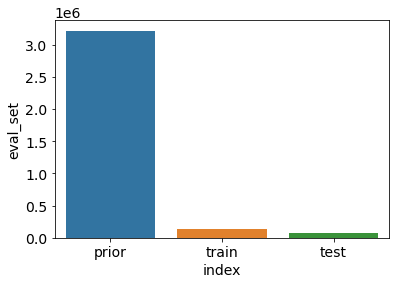

In [48]:
sns.barplot(x='index', y='eval_set', data=cnt)

In [49]:
len(order_info['user_id'].unique())

206209

## 消費者下單次數

In [50]:
#觀察消費者下了幾次單 ：user_id 的 order_number 的 size 
cnt = order_info.groupby(['user_id'])['order_number'].size().reset_index()

C:\Users\wonglab\.conda\envs\Q\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_number'>

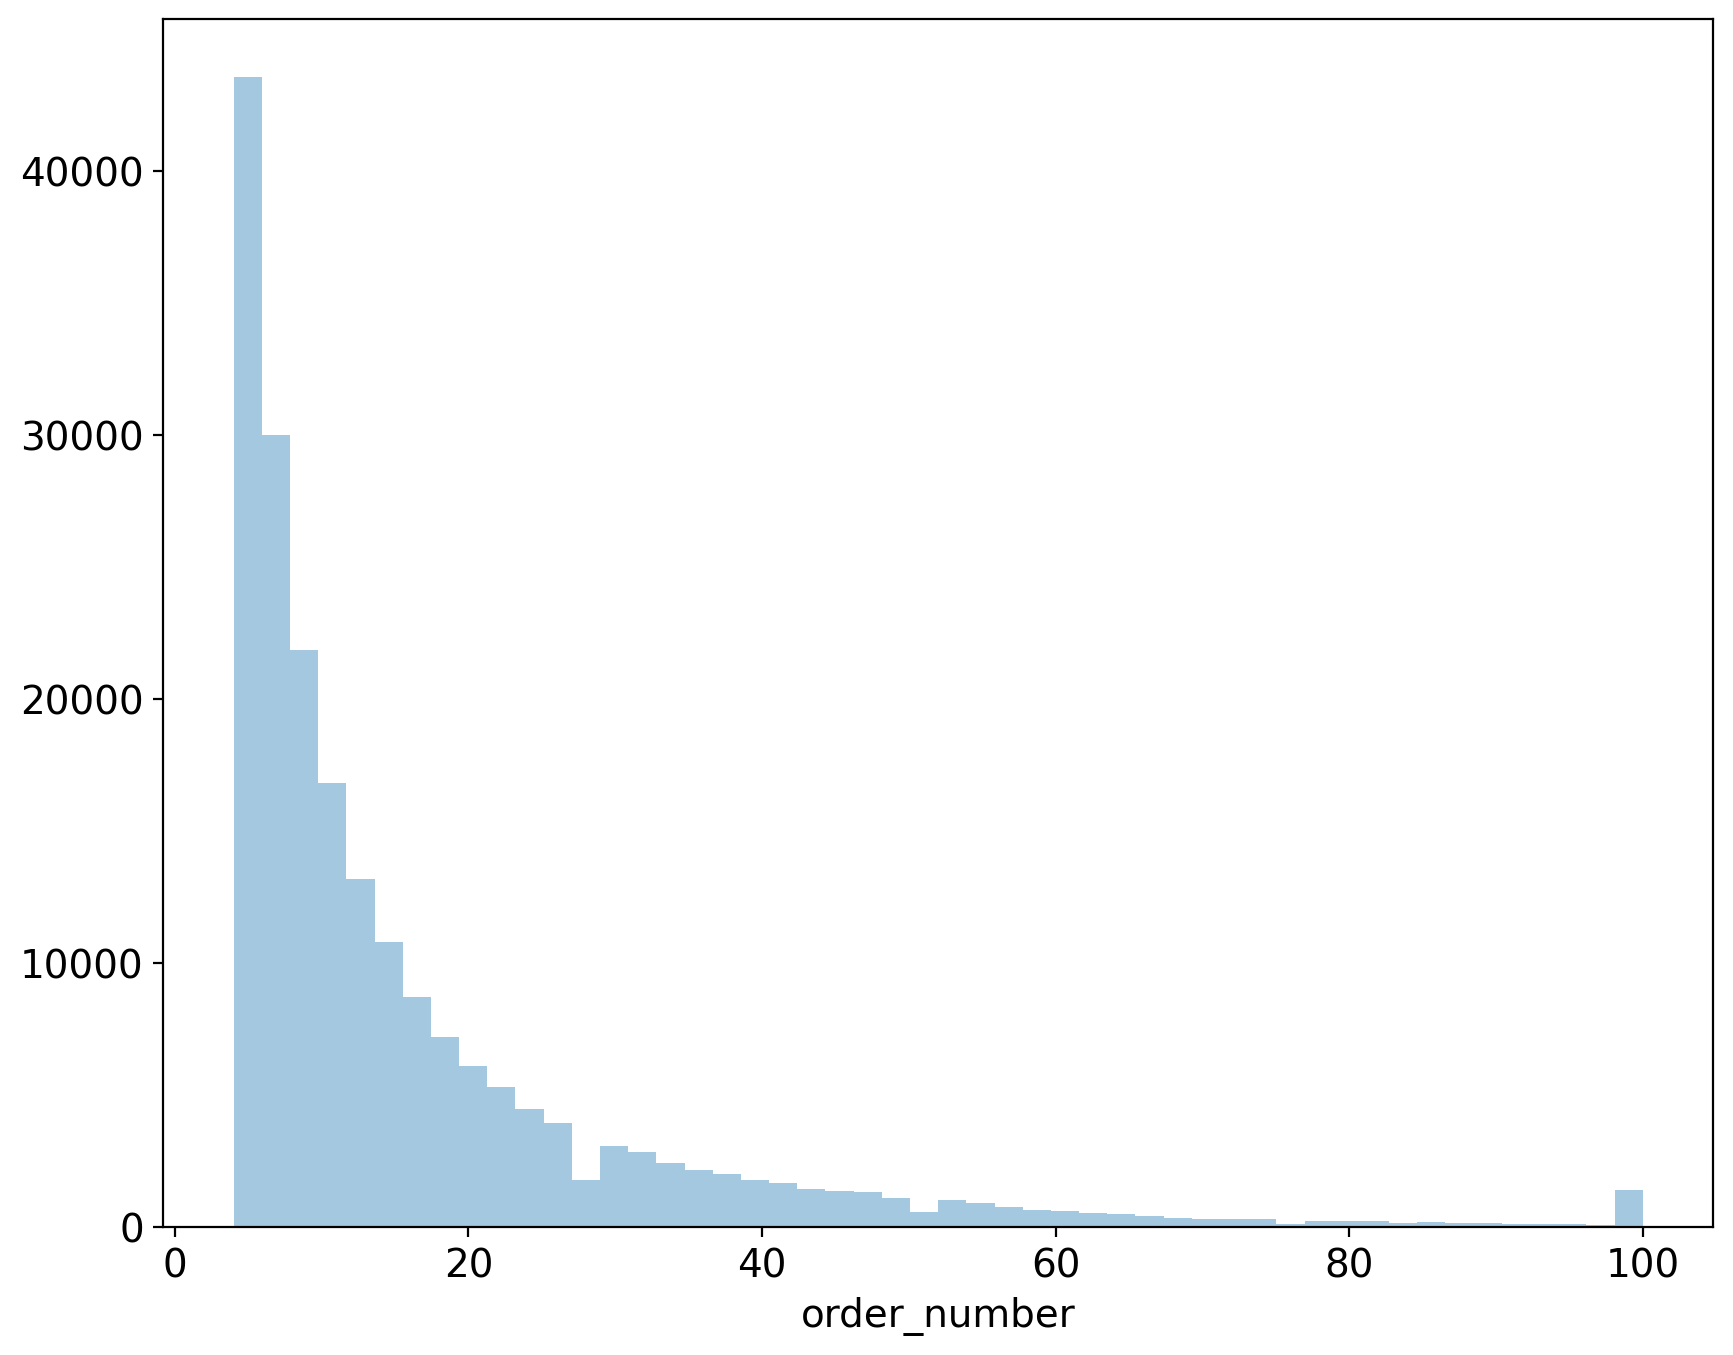

In [51]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
sns.distplot(cnt.order_number, kde=False)
# plt.hist(cnt.order_number, bins=50)

## 每一單買幾個商品 basket_size

<AxesSubplot:>

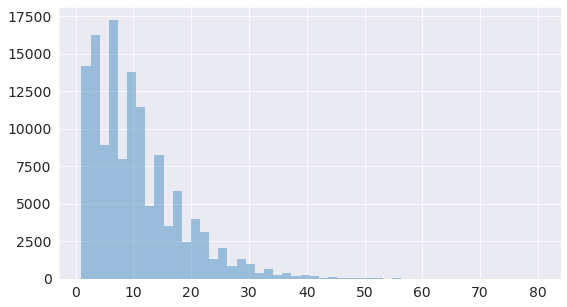

In [52]:
# 每個order中買了幾個product

bsize = order_train.groupby(['order_id']).size()
ax = start_plot(style='darkgrid', figsize=(9, 5))
sns.distplot(bsize, ax=ax, kde=False)

##通常買十個商品

## best sellers 銷售排行榜

<BarContainer object of 20 artists>

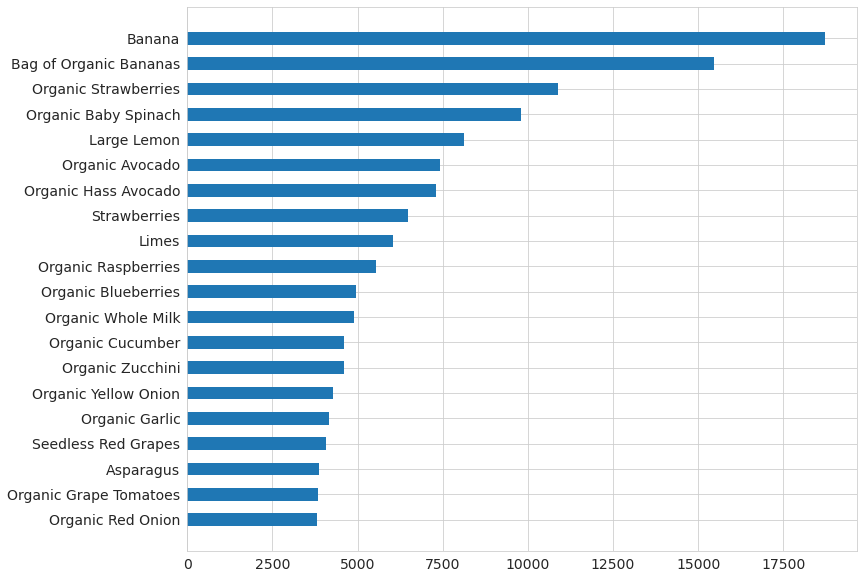

In [53]:
#每個order id 對應到的product_id, 再lookup對應的product name
#故 merge

#先列出前20種
best_seller = tx['product_name'].value_counts()[:20][::-1]
##從top 1 開始
ax = start_plot(figsize=(12, 10))
plt.barh(best_seller.index, best_seller.values, height=0.5)

In [ ]:
# 總排行榜得出，但並非消費者推薦系統的best practice

## 消費者偏好的購物時間 when do people buy

<AxesSubplot:xlabel='order_dow', ylabel='count'>

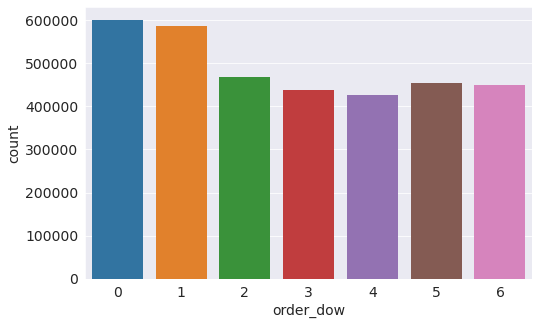

In [54]:
ax = start_plot(figsize=(8, 5), style='darkgrid')
sns.countplot(x = 'order_dow', data=order_info, ax=ax)

# 資料並無說明day of week 的 values 是從禮拜幾開始算
# 推測 2, 3, 4, 5, 6是週一到週五

Wall time: 271 ms


C:\Users\wonglab\.conda\envs\Q\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'counts')

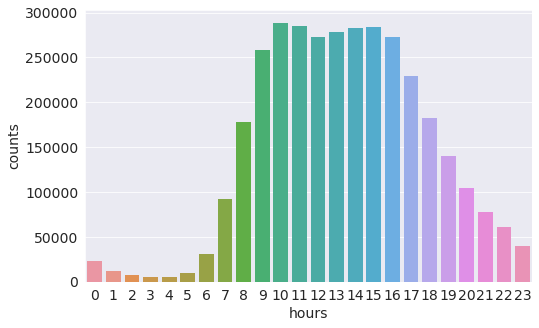

In [55]:
%%time

hours = order_info.groupby(['order_hour_of_day']).size()
days_since_last_purchase = \
    order_info.groupby(['days_since_prior_order']).size()

ax = start_plot(figsize=(8, 5), style='darkgrid')
sns.barplot(hours.index, hours.values, ax=ax)
ax.set_xlabel('hours')
ax.set_ylabel('counts')

dow = 1, 九點十點的時候下單次數較多，可推測當天為假日

**10 ~ 16 下單最多**

Text(0, 0.5, 'counts')

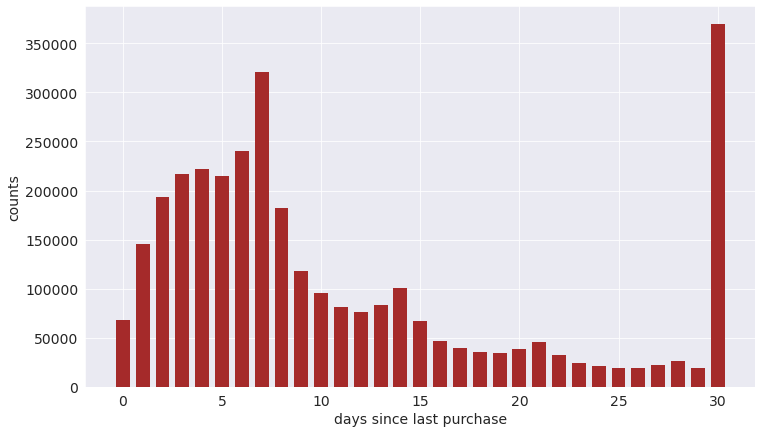

In [56]:
ax = start_plot(figsize=(12, 7), style='darkgrid')
ax.bar(days_since_last_purchase.index, 
       days_since_last_purchase.values,
       width=0.7, color='brown')
ax.set_xlabel('days since last purchase')
ax.set_ylabel('counts')

**<font color='yellow'>可看出大約每七天會再次購買 (7, 14, 21)，<br><br>
30 天才買一次**<font color='brown'>

In [57]:
gdf = order_info.groupby(['order_dow', 'order_hour_of_day'])['order_number'].size().reset_index()
gdf = gdf.pivot('order_dow', 'order_hour_of_day', 'order_number')
gdf

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,...,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,...,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,...,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,...,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,...,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645
5,3189,1672,1016,841,910,1574,4866,13434,24015,34232,...,37407,37508,35860,29955,24310,18741,13322,9515,7498,5265
6,3306,1919,1214,863,802,1136,3243,11319,22960,30839,...,38748,38093,35562,30398,24157,18346,13392,10501,8532,6087


Text(0.5, 1.0, 'Frequency 0f Day of Week vs. Hour of Day')

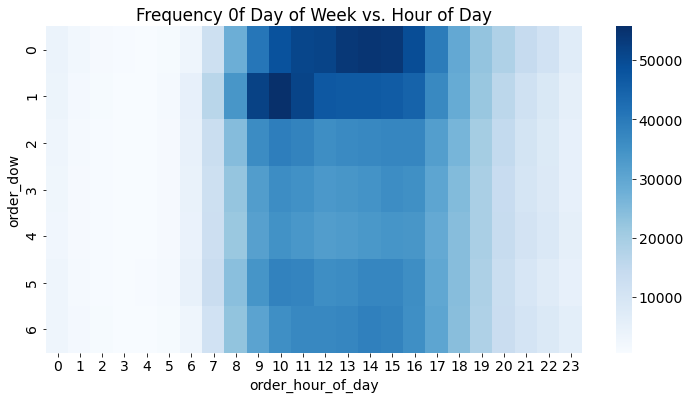

In [58]:
plt.figure(figsize=(12, 6))
sns.heatmap(gdf, cmap='Blues')
plt.title('Frequency 0f Day of Week vs. Hour of Day')

## 商品重複購買的比率

In [59]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


reordered
0    0.401406
1    0.598594
dtype: float64

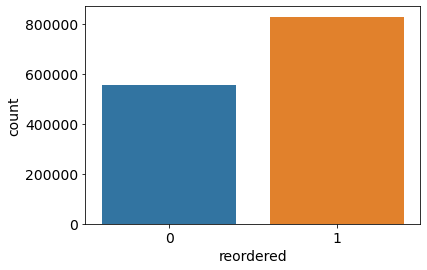

In [61]:
sns.countplot(x='reordered', data=order_train)
ratios = order_train.groupby(['reordered']).size() / len(order_train)
ratios

<font color='yellow'> reordered : ordered = 6:4<font>

In [64]:
a = order_train.groupby(['product_id'])['reordered'].aggregate('sum').reset_index()
b = a[a['reordered'] == 0]
b

,product_id,reordered
11,13,0
12,14,0
13,15,0
14,16,0
16,21,0
...,...,...
39098,49653,0
39100,49658,0
39101,49659,0
39118,49682,0


In [65]:
prods.shape, len(order_train['product_id'].unique())

((49688, 4), 39123)

In [66]:
8947 / prods.shape[0], 8947/len(order_train['product_id'].unique())

(0.18006359684430848, 0.22868900646678425)

In [78]:
a = tx.groupby(['order_id'])['reordered'].aggregate('sum').reset_index()
len(a[a['reordered'] == 0]) / len(tx['order_id'].unique())

0.06555952716658156

In [82]:
rbm = order_train.groupby(['product_id'])['reordered'].sum()
rdf = pd.DataFrame(data=rbm.values, index=rbm.index, columns=['reordered'])
rdf['total'] = order_train.groupby(['product_id'])['order_id'].count()
rdf['ratio'] = (rdf['reordered'] / rdf['total']).round(3)

In [83]:
rdf[rdf['reordered'] == 0]

,reordered,total,ratio
product_id,,,
13,0,1,0.0
14,0,1,0.0
15,0,2,0.0
16,0,1,0.0
21,0,1,0.0
...,...,...,...
49653,0,1,0.0
49658,0,1,0.0
49659,0,8,0.0


重購比例最高的十個商品：

- n: 每個產品出現的次數，也就是被購買的總數
- repeat_buying_orders: 若每個產品出現時， reordered 欄位也是1，表示這是重複購買，我們要計算這種訂單的總數
-----------

$產品重購比例=\frac{重複購買次數}{總購買數}$

In [91]:
r1 = order_train.groupby(['reordered', 'product_id']).size().loc[1]
n = order_train.groupby(['product_id']).size()

ratio = r1/n
#有NAN

ratio_df = pd.DataFrame({'total_orders': n, 'reordered_ratio': ratio})
ratio_df.fillna(0, inplace=True)
ratio_df = ratio_df.reset_index()
ratio_df

,product_id,total_orders,reordered_ratio
0,1,76,0.644737
1,2,4,0.250000
2,3,6,1.000000
3,4,22,0.636364
4,5,1,1.000000
...,...,...,...
39118,49682,5,0.000000
39119,49683,2413,0.708247
39120,49686,7,0.714286
39121,49687,1,0.000000


In [94]:
prods2 = pd.merge(prods, ratio_df, how='inner')
prods2.head()

,product_id,product_name,aisle_id,department_id,total_orders,reordered_ratio
0,1,Chocolate Sandwich Cookies,61,19,76,0.644737
1,2,All-Seasons Salt,104,13,4,0.250000
2,3,Robust Golden Unsweetened Oolong Tea,94,7,6,1.000000
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,0.636364
4,5,Green Chile Anytime Sauce,5,13,1,1.000000


In [97]:
p2 = prods2.sort_values(by='reordered_ratio', ascending=False)
p2 = p2[p2['total_orders'] > 50]
p2.head(10)

,product_id,product_name,aisle_id,department_id,total_orders,reordered_ratio
1374,1729,2% Lactose Free Milk,84,16,92,0.934783
16529,20940,Organic Low Fat Milk,84,16,368,0.913043
9571,12193,100% Florida Orange Juice,98,7,59,0.898305
16610,21038,Organic Spelt Tortillas,128,3,81,0.888889
19574,24852,Banana,24,4,18726,0.884172
100,117,Petit Suisse Fruit,2,16,120,0.883333
30852,39180,Organic Lowfat 1% Milk,84,16,483,0.881988
9723,12384,Organic Lactose Free 1% Lowfat Milk,91,16,269,0.881041
18956,24024,1% Lowfat Milk,84,16,461,0.878525
28917,36717,Double Fiber Bread,112,3,81,0.876543


## 放進購物車的順序與是否為重複購買的關聯


## 哪些商品第一個被擺入購物車？

<AxesSubplot:xlabel='add_to_cart_order', ylabel='reordered_ratio'>

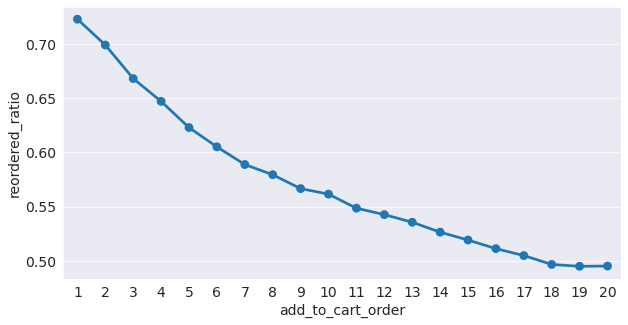

In [100]:
a = tx.groupby(['add_to_cart_order', 'reordered']).size()
n = tx.groupby(['add_to_cart_order']).size()

top_k = 20
pct = np.zeros((top_k))
for i in range(top_k):
    pct[i] = a[i+1].loc[1] / n.loc[i+1]

ax = start_plot(figsize=(10, 5), style='darkgrid')
# ax.plot(range(1, 21, 1), pct, marker='X', color='navy')

d = pd.DataFrame({'add_to_cart_order': range(1, 21, 1),
          'reordered_ratio': pct})
sns.pointplot(x='add_to_cart_order', y='reordered_ratio', data=d)

let product_id = k

- 分母: k 被購買的總次數
- 分子 #1: k 是重購，而且是第一個被加入購物車的次數 .sum()
- 分子 #2: k 第一個被加入購物車的次數 .count()

## 顧客分群 Segmentation

In [101]:
%%time
tx = pd.merge(order_train, prods, how='inner')
tx = pd.merge(tx, order_info, how='inner')
tx = pd.merge(tx, aisles, how='inner')
tx.head()

Wall time: 1.8 s


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,yogurt
1,816049,49302,7,1,Bulgarian Yogurt,120,16,47901,train,14,4,6,16.0,yogurt
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,2993,train,15,0,7,7.0,yogurt
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,41425,train,4,3,8,14.0,yogurt
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,187205,train,5,4,14,30.0,yogurt


In [102]:
%%time
cust = pd.crosstab(tx['user_id'], tx['aisle'])

Wall time: 9.14 s


可觀察到每個user買的小分類，利用這種方式做顧客分群

In [103]:
cust.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [104]:
sys.getsizeof(tx), sys.getsizeof(cust)

(431503096, 141705744)

In [ ]:
hd_path = os.path.join(data_dir, 'cart.h5')
tx.to_hdf(hd_path, 'transaction complete')
cust.to_hdf(hd_path, 'customer orders')

In [ ]:
tx = pd.read_hdf(hd_path, 'transaction complete')
cust = pd.read_hdf(hd_path, 'customer orders')

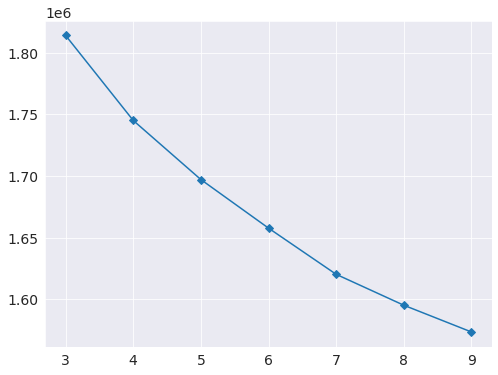

In [110]:
from sklearn.cluster import KMeans

models = [KMeans(n_clusters=k).fit(cust) for k in range(3, 10)]
elbows_scores = [model.inertia_ for model in models]

ax = start_plot(style='darkgrid', figsize=(8, 6))
ax.plot(range(3, 10), elbows_scores, marker='D')

In [111]:
%%time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=7)
pca.fit(cust)
pca_samples = pca.transform(cust)
ps = pd.DataFrame(pca_samples)

n_k = 7
model = KMeans(n_clusters=n_k)
labels = model.fit_predict(ps)

model.inertia_

Wall time: 3.13 s


476479.6384972243

In [112]:
cu2 = cust.copy()
cu2.insert(0, 'cluster', labels)

In [113]:
cu2.head()

aisle,cluster,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [114]:
cu2.groupby(['cluster']).sum()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
cluster,,,,,,,,,,,,,,,,,,,,,
0,226,1269,68,85,1525,362,2901,245,72,268,...,3239,2331,957,1830,414,404,485,9122,225,6949
1,45,406,21,30,735,88,748,61,16,68,...,1056,786,284,592,116,101,136,2645,37,22002
2,30,945,20,22,695,56,1192,54,11,15,...,870,612,763,938,46,59,138,1911,14,4692
3,155,1787,49,48,887,194,2594,189,39,111,...,1921,1196,1315,1826,111,189,279,4738,120,6010
4,75,880,50,34,1412,164,1532,83,26,46,...,1856,1099,767,1390,141,110,279,4064,41,8212
5,6,51,17,19,6715,3,114,10,1,3,...,132,60,68,79,11,15,20,342,2,1006
6,530,1669,81,90,1229,634,4007,452,122,1328,...,3028,3292,969,1698,624,743,632,13795,649,6369


In [117]:
pref_by_clusters = cu2.groupby('cluster').sum()
for i in range(n_k):
    print('cluster %d' % (i + 1))
    print('------')
    print(pref_by_clusters.loc[i].sort_values(ascending=False))
    print('')

cluster 1
------
aisle
fresh fruits                     51834
packaged vegetables fruits       17288
fresh vegetables                 10034
packaged cheese                   9149
water seltzer sparkling water     9122
                                 ...  
frozen juice                        88
baby bath body care                 85
beauty                              72
baby accessories                    68
specialty wines champagnes          65
Name: 0, Length: 134, dtype: int64

cluster 2
------
aisle
yogurt                        22002
fresh fruits                   9425
packaged vegetables fruits     4964
fresh vegetables               4904
packaged cheese                3753
                              ...  
eye ear care                     24
baby accessories                 21
beauty                           16
specialty wines champagnes       14
kitchen supplies                 10
Name: 1, Length: 134, dtype: int64

cluster 3
------
aisle
fresh vegetables              4355

# End of File